# Alzheimer's Prediction using MMSE Features

In [5]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression tools
from Logistic_bootstrap_metrics import bootstrap_metrics, plot_roc_curve, build_summary_table, plot_bootstrapped_roc_curve

# Machine Learning Tools
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve, 
    auc
)




## Load and Prepare Data

In [6]:
# Load dataset
df = pd.read_csv("data/Filtered_Data.csv")

# Split into train and test based on 'Split' column
df_train = df[df['Split'] == 'Train']
df_test = df[df['Split'] == 'Test']

# Define MMSE question columns
mmse_cols = [
    "MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE",
    "MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR",

    "WORD1", "WORD2", "WORD3",

    "MMD", "MML", "MMR", "MMO", "MMW",

    "WORD1DL", "WORD2DL", "WORD3DL",

    "MMWATCH", "MMPENCIL", "MMREPEAT",
    "MMHAND", "MMFOLD", "MMONFLR",
    "MMREAD", "MMWRITE", 
    
    "MMDRAW"
]

# Define MMSE question categories
categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Registration": ["WORD1", "WORD2", "WORD3"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE"],
    "Copy": ["MMDRAW"]
}

# Significant categories
significant_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE"],
}

# BioBERT embeddings
df_numerical_biobert_train = pd.read_csv("data/Embeddings/Numerical_BioBERT_Train.csv")
df_numerical_biobert_test = pd.read_csv("data/Embeddings/Numerical_BioBERT_Test.csv")

df_biobert_train = pd.read_csv("data/Embeddings/BioBERT_Train.csv")
df_biobert_test = pd.read_csv("data/Embeddings/BioBERT_Test.csv")

df_context_biobert_test = pd.read_csv("data/Embeddings/Context_BioBERT_Train.csv")
df_context_biobert_train = pd.read_csv("data/Embeddings/Context_BioBERT_Test.csv")

# ClinicalBERT embeddings
df_numerical_clinicalbert_train = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Train.csv")
df_numerical_clinicalbert_test = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Test.csv")

df_clincalbert_train = pd.read_csv("data/Embeddings/ClinicalBERT_Train.csv")
df_clincalbert_test = pd.read_csv("data/Embeddings/ClinicalBERT_Test.csv")

df_context_clinicalbert_test = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Train.csv")
df_context_clinicalbert_train = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Test.csv")

# MedBERT embeddings
df_numerical_medbert_train = pd.read_csv("data/Embeddings/Numerical_MedBERT_Train.csv")
df_numerical_medbert_test = pd.read_csv("data/Embeddings/Numerical_MedBERT_Test.csv")

df_medbert_train = pd.read_csv("data/Embeddings/MedBERT_Train.csv")
df_medbert_test = pd.read_csv("data/Embeddings/MedBERT_Test.csv")

df_context_medbert_test = pd.read_csv("data/Embeddings/Context_MedBERT_Train.csv")
df_context_medbert_train = pd.read_csv("data/Embeddings/Context_MedBERT_Test.csv")


## Helper Functions

In [16]:
def prepare_features_for_logistic_regression(X_train, X_test, variance_threshold=1e-5, correlation_threshold=0.98):
    
    # Step 1: Remove constant (zero variance) features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_reduced = selector.fit_transform(X_train)
    X_test_reduced = selector.transform(X_test)
    # Get the names of the features that were kept
    print(f"Original number of features: {X_train.shape[1]}")

    kept_features = X_train.columns[selector.get_support()]
    X_train_reduced = pd.DataFrame(X_train_reduced, columns=kept_features, index=X_train.index)
    X_test_reduced = pd.DataFrame(X_test_reduced, columns=kept_features, index=X_test.index)

    print(f"Number of features after variance thresholding: {X_train_reduced.shape[1]}")

    # Step 2: Remove highly correlated features
    corr_matrix = X_train_reduced.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Number of features to drop due to correlation: {len(to_drop)}")
    print(f"Number of total features after dropping correlated features: {X_train_reduced.shape[1] - len(to_drop)}")

    X_train_final = X_train_reduced.drop(columns=to_drop, errors='ignore')
    X_test_final = X_test_reduced.drop(columns=to_drop, errors='ignore')

    return X_train_final, X_test_final

def run_logistic_regression_pipeline(train_df, test_df, embedding_cols, categories, model_name, target_var='AD', n_bootstrap=1000):
    print(f"\nRunning combined logistic regression for {model_name} (mean embeddings per category per visit)")

    def compute_category_means_per_visit(df, embedding_cols, mmse_codes_dict, last_visit_only=False):
        category_mean_features = []  # Use a list to collect rows
        for (subject, visit), group in df.groupby(['subject_id', 'visit']):
            if last_visit_only and visit != df[df['subject_id'] == subject]['visit'].iloc[-1]:
                continue

            visit_means = {}
            for category, codes in mmse_codes_dict.items():
                filtered = group[group['MMSE Code'].isin(codes)]
                if not filtered.empty:
                    mean_embeddings = filtered[embedding_cols].mean()
                    for col in mean_embeddings.index:
                        visit_means[f'{category}_{col}'] = mean_embeddings[col]
            visit_means['subject_id'] = subject
            visit_means['visit'] = visit
            category_mean_features.append(visit_means)  # Append the dictionary to the list

        # Convert the list of dictionaries to a DataFrame
        category_mean_features = pd.DataFrame(category_mean_features)
        return category_mean_features
    
    train_df['subject_id'] = train_df['subject_id'].astype(str)
    test_df['subject_id'] = test_df['subject_id'].astype(str)

    train_means = compute_category_means_per_visit(train_df, embedding_cols, categories)
    test_means = compute_category_means_per_visit(test_df, embedding_cols, categories, last_visit_only=True)

    train_labels = train_df[['subject_id', 'visit', target_var]].drop_duplicates().set_index(['subject_id', 'visit'])
    test_labels = test_df[['subject_id', 'visit', target_var]].drop_duplicates().set_index(['subject_id', 'visit'])

    train_means = train_means.set_index(['subject_id', 'visit']).join(train_labels).dropna()
    test_means = test_means.set_index(['subject_id', 'visit']).join(test_labels).dropna()

    X_train_combined = train_means.drop(columns=[target_var])
    y_train_combined = train_means[target_var]
    X_test_combined = test_means.drop(columns=[target_var])
    y_test_combined = test_means[target_var]

    combined_result = bootstrap_metrics(
        df_train=X_train_combined,
        df_test=X_test_combined,
        independent_vars=X_train_combined.columns.tolist(),
        dep_var_train=y_train_combined,
        dep_var_test=y_test_combined,
        n_bootstrap=n_bootstrap
    )

    print(f"\n=== Results for {model_name} ===")
    print("\n----- Odds Ratios (one-time fit) -----")
    print(combined_result["Odds Ratios (one-time fit)"])
    print(f"\nBest Threshold Automatically Found: {combined_result['Best Threshold']:.2f}")

    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in combined_result["Bootstrapped Metrics"].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

    plot_bootstrapped_roc_curve(
        combined_result["Bootstrapped ROC Curve"],
        title=f"ROC Curves - {model_name}",
    )

    return combined_result

def drop_highly_correlated_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_features = upper.index[upper[column] > threshold].tolist()
            to_drop.append(column)
            
    # Drop duplicated entries
    to_drop = list(set(to_drop))
    return to_drop

def select_good_questions(results, pval_threshold=0.05):
    good_questions = []
    bad_questions = []

    for res in results:
        try:
            p_value = res['Odds Ratios']['p-value'].iloc[1]  # assuming feature is second row

            if p_value <= pval_threshold:
                good_questions.append(res['Question'])
            else:
                bad_questions.append(res['Question'])
        except Exception as e:
            print(f"Error processing {res['Question']}: {e}")
            bad_questions.append(res['Question'])

    return good_questions, bad_questions

def update_categories_with_good_questions(categories, good_questions):
    updated_categories = {}

    for cat_name, questions in categories.items():
        filtered_questions = [q for q in questions if q in good_questions]
        if filtered_questions:
            updated_categories[cat_name] = filtered_questions

    return updated_categories


## Logistic Regression on MMSCORE with Bootstrapping

Using class weighting automatically.
Best Threshold found automatically: 0.33


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



===== Odds Ratios (one-time fit) — MMSE Score =====
           Odds Ratio   95% CI Lower  95% CI Upper       p-value
const    1.108315e+07  584766.636652  2.100603e+08  3.205904e-27
MMSCORE  5.208992e-01       0.467053  5.809535e-01  1.066395e-31

Best Threshold Automatically Found: 0.33

===== Bootstrapped Metrics (1000 runs) - MMSE Score =====
AUC: Mean = 0.8639, 95% CI = [0.8506, 0.9151]
Balanced Accuracy: Mean = 0.8087, 95% CI = [0.7955, 0.8377]
Sensitivity: Mean = 0.6671, 95% CI = [0.6429, 0.7143]
Specificity: Mean = 0.9503, 95% CI = [0.9481, 0.9610]
Precision: Mean = 0.7097, 95% CI = [0.6923, 0.7692]
F1-score: Mean = 0.6873, 95% CI = [0.6667, 0.7407]


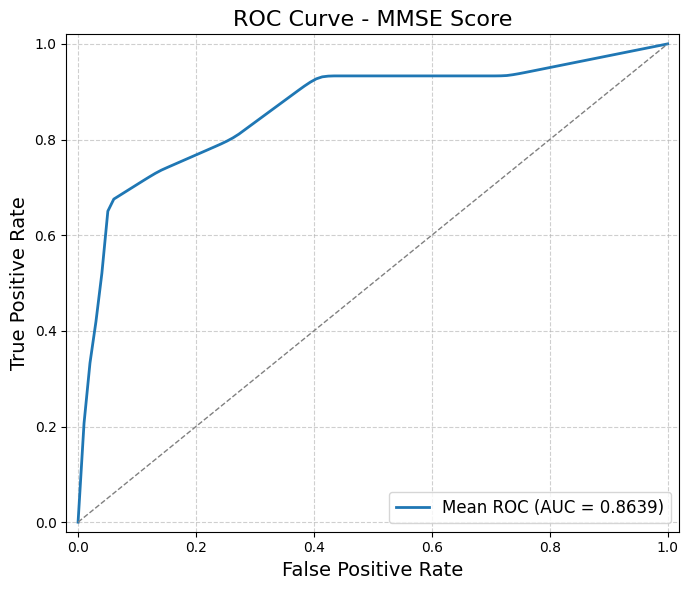

In [8]:
# Define features and target
X_train = df_train[['MMSCORE', 'subject_id']]  # Include 'subject_id' in X_train
y_train = df_train['AD']
X_test = df_test[['MMSCORE', 'subject_id']]  # Include 'subject_id' in X_test
y_test = df_test['AD']

# Use only the last visit for each subject in the test set
X_test = X_test.drop_duplicates(subset=['subject_id'], keep='last')
y_test = y_test[X_test.index]  # Align y_test with the filtered X_test

# Drop 'subject_id' from X_train and X_test
X_train = X_train.drop(columns=['subject_id'])
X_test = X_test.drop(columns=['subject_id'])

# Run bootstrapped logistic regression
mmsescore_results = bootstrap_metrics(
    df_train=X_train,
    df_test=X_test,
    independent_vars=['MMSCORE'],
    dep_var_train=y_train,
    dep_var_test=y_test,
    n_bootstrap=1000
)

# Display results
print("\n===== Odds Ratios (one-time fit) — MMSE Score =====")
print(mmsescore_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {mmsescore_results['Best Threshold']:.2f}")

print("\n===== Bootstrapped Metrics (1000 runs) - MMSE Score =====")
for metric, (mean, ci) in mmsescore_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve
# plot_roc_curve(mmsescore_results["True Labels"], mmsescore_results["Predicted Probabilities"], title="ROC Curve - MMSE Score")

plot_bootstrapped_roc_curve(
    mmsescore_results["Bootstrapped ROC Curve"],
    title="ROC Curve - MMSE Score"
)


## Logistic Regression on MMSE Category with Bootstrapping

Using class weighting automatically.
Best Threshold found automatically: 0.23


/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_81266/4141877533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_81266/4141877533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_81266/4141877533.py:6: SettingWithCopyWarning: 
A value


============ Category Results ============
----- Odds Ratios (one-time fit) -----
                         Odds Ratio  95% CI Lower  95% CI Upper       p-value
const                  2.457445e-81      0.000000           inf  9.998351e-01
Orientation_Time       3.426769e-01      0.253465      0.463288  3.387871e-12
Orientation_Place      4.637707e-01      0.294825      0.729529  8.861841e-04
Registration           7.616571e+28      0.000000           inf  9.998227e-01
Attention_Calculation  6.547111e-01      0.485426      0.883033  5.521669e-03
Recall                 5.169778e-01      0.423374      0.631276  9.558209e-11
Language               6.304347e-01      0.411382      0.966128  3.416009e-02
Copy                   7.319458e-01      0.347403      1.542140  4.118152e-01

Best Threshold Automatically Found: 0.23

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.8549, 95% CI = [0.8400, 0.9054]
Balanced Accuracy: Mean = 0.7927, 95% CI = [0.7792, 0.8214]
Sensitivity: Mean = 0

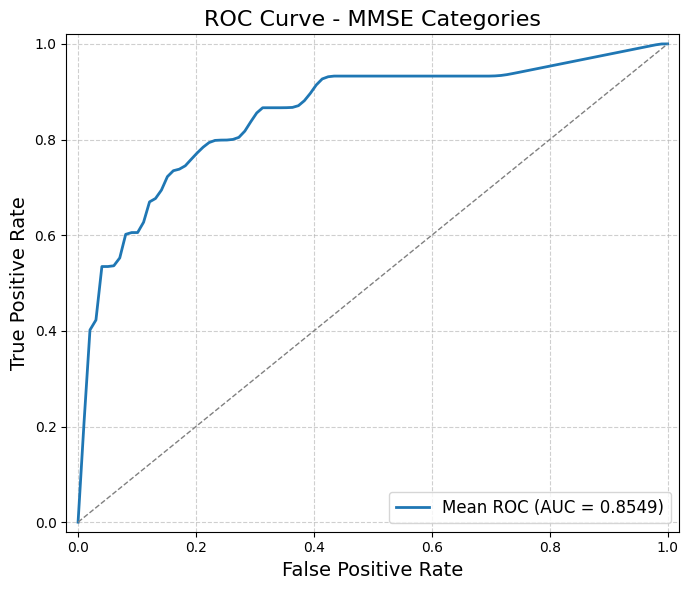


Significant categories selected:
 - Orientation_Time
 - Orientation_Place
 - Attention_Calculation
 - Recall
 - Language


In [9]:
# Use only the last visit for each subject in the test set
df_test = df_test.groupby('subject_id').last().reset_index()

# Create composite scores for each category
for category, questions in categories.items():
    df_train[f"{category}"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}"] = df_test[questions].sum(axis=1, skipna=True)

# ======= Logistic Regression on Combined Model =======
combined_features = [f"{category}" for category in categories.keys()]
X_train_combined = df_train[combined_features]
X_test_combined = df_test[combined_features]
y_train_combined = df_train['AD']
y_test_combined = df_test['AD']

# Run logistic regression on the combined model
combined_category_results = bootstrap_metrics(
    df_train=X_train_combined,
    df_test=X_test_combined,
    independent_vars=combined_features,
    dep_var_train=y_train_combined,
    dep_var_test=y_test_combined,
    n_bootstrap=1000
)

# Display combined results
print("\n============ Category Results ============")
print("----- Odds Ratios (one-time fit) -----")
print(combined_category_results["Odds Ratios (one-time fit)"])
print(f"\nBest Threshold Automatically Found: {combined_category_results['Best Threshold']:.2f}")
print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in combined_category_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for combined model
plot_bootstrapped_roc_curve(
    combined_category_results["Bootstrapped ROC Curve"],
    title="ROC Curve - MMSE Categories"
)

# Analyze p-values of combined model
combined_odds_ratios = combined_category_results["Odds Ratios (one-time fit)"]
significant_categories_ = combined_odds_ratios[(combined_odds_ratios['p-value'] < 0.05) & (~combined_odds_ratios.index.str.contains('const'))].index.tolist()
print(f"\nSignificant categories selected:")
for category in significant_categories_:
    print(f" - {category}")

## Logistic Regression on Significant MMSE Category with Bootstrapping

Using class weighting automatically.
Best Threshold found automatically: 0.21


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Significant Categoies ============
----- Odds Ratios (one-time fit) -----
                          Odds Ratio  95% CI Lower  95% CI Upper       p-value
const                  404239.467499   5707.062523  2.863286e+07  2.864661e-09
Orientation_Time            0.366535      0.274015  4.902938e-01  1.360848e-11
Orientation_Place           0.466215      0.299230  7.263862e-01  7.437902e-04
Attention_Calculation       0.627587      0.471508  8.353302e-01  1.406803e-03
Recall                      0.521653      0.428073  6.356919e-01  1.110436e-10
Language                    0.675502      0.442353  1.031534e+00  6.933577e-02

Best Threshold Automatically Found: 0.21

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.8509, 95% CI = [0.8358, 0.9003]
Balanced Accuracy: Mean = 0.7989, 95% CI = [0.7857, 0.8279]
Sensitivity: Mean = 0.7336, 95% CI = [0.7143, 0.7857]
Specificity: Mean = 0.8642, 95% CI = [0.8571, 0.8831]
Precision: Mean = 0.4957, 95% CI = [0.4762, 0

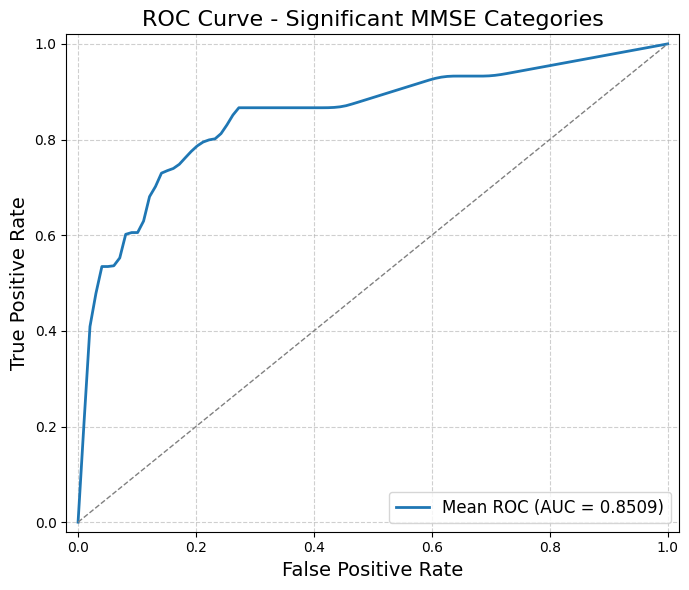

In [10]:
# Prepare train and test data for combined model
X_train_significant = df_train[significant_categories_]
X_test_significant = df_test[significant_categories_]
y_train_significant = df_train['AD']
y_test_significant = df_test['AD']

# Drop them
X_train_final = X_train_significant
X_test_final = X_test_significant


# Run logistic regression on significant combined model
significant_combined_results = bootstrap_metrics(
    df_train=X_train_final,
    df_test=X_test_final,
    independent_vars=X_train_final.columns.tolist(),
    dep_var_train=y_train_significant,
    dep_var_test=y_test_significant,
    n_bootstrap=1000
)

# Display new combined model
print("\n============ Results for Significant Categoies ============")
print("----- Odds Ratios (one-time fit) -----")
print(significant_combined_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {significant_combined_results['Best Threshold']:.2f}")

print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in significant_combined_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Plot ROC Curve
plot_bootstrapped_roc_curve(
    significant_combined_results["Bootstrapped ROC Curve"],
    title="ROC Curve - Significant MMSE Categories"
)

## Logisitc Regression on Numerical ClinicalBERT Embeddings 


Running combined logistic regression for Numerical ClinicalBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.21

=== Results for Numerical ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                        Odds Ratio  95% CI Lower  \
const                                     1.003923           0.0   
Orientation_Time_Numerical_Embedding_0    0.960679           NaN   
Orientation_Time_Numerical_Embedding_1    0.968502           NaN   
Orientation_Time_Numerical_Embedding_2    0.988869           0.0   
Orientation_Time_Numerical_Embedding_3    1.042469           NaN   
...                                            ...           ...   
Language_Numerical_Embedding_763          1.023040           NaN   
Language_Numerical_Embedding_764          0.985803           NaN   
Language_Numerical_Embedding_765          1.029321           0.0   
Language_Numerical_Embedding_766          0.992521           0.0   
Language_Numerical_Embedding_767          1.003063           0.0   

                                        95% CI Upper  p-va

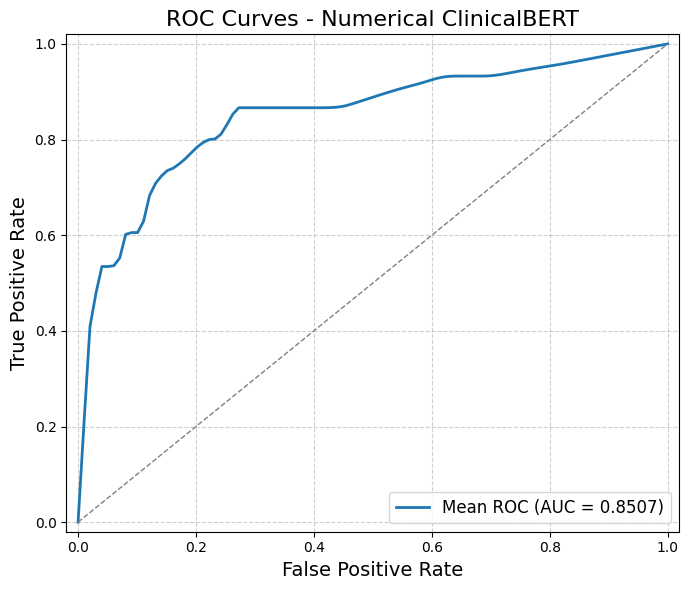

In [17]:
numerical_clinicalbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_clinicalbert_train,
    test_df=df_numerical_clinicalbert_test,
    embedding_cols=[col for col in df_numerical_clinicalbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=significant_categories,
    model_name="Numerical ClinicalBERT",
    n_bootstrap=1000
)

## Logistic regression on ClinicalBERT embeddings.


Running combined logistic regression for ClinicalBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

Best Threshold found automatically: 0.12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Pytho


=== Results for ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                              Odds Ratio  95% CI Lower  95% CI Upper  \
const                                inf           0.0           inf   
Orientation_Time_Embedding_0         inf           NaN           NaN   
Orientation_Time_Embedding_1         inf           0.0           inf   
Orientation_Time_Embedding_2         0.0           0.0           inf   
Orientation_Time_Embedding_3         0.0           0.0           inf   
...                                  ...           ...           ...   
Language_Embedding_763               inf           NaN           NaN   
Language_Embedding_764               inf           inf           inf   
Language_Embedding_765               0.0           NaN           NaN   
Language_Embedding_766               0.0           NaN           NaN   
Language_Embedding_767               0.0           0.0           inf   

                                   p-value  
const           

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


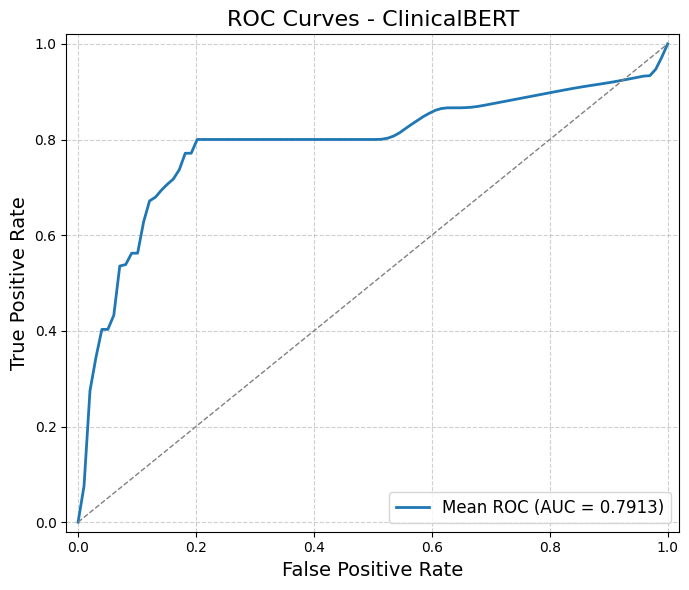

In [18]:
clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_clincalbert_train,
    test_df=df_clincalbert_test,
    embedding_cols=[col for col in df_clincalbert_train.columns if col.startswith('Embedding_')],
    categories=significant_categories,
    model_name="ClinicalBERT"
)

## Logistic Regression on Contextual ClinicalBERT embeddings


Running combined logistic regression for Contextual ClinicalBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.34

=== Results for Contextual ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                      Odds Ratio  95% CI Lower  95% CI Upper  \
const                                   1.239498           0.0           inf   
Orientation_Time_Context_Embedding_0    0.493476           NaN           NaN   
Orientation_Time_Context_Embedding_1   11.883079           NaN           NaN   
Orientation_Time_Context_Embedding_2   15.211920           NaN           NaN   
Orientation_Time_Context_Embedding_3    1.418298           NaN           NaN   
...                                          ...           ...           ...   
Language_Context_Embedding_763          2.317203           0.0           inf   
Language_Context_Embedding_764          0.763331           NaN           NaN   
Language_Context_Embedding_765          0.002450           0.0           inf   
Language_Context_Embedding_766          0.409031           0.0           i

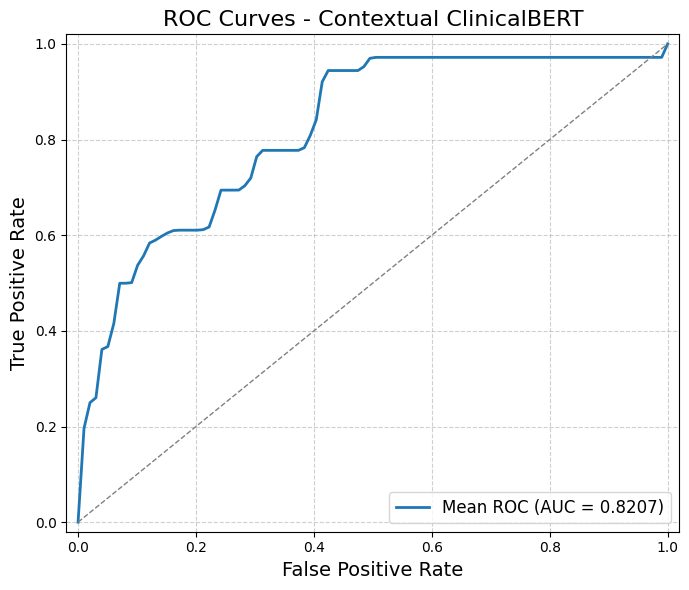

In [19]:
context_clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_clinicalbert_train,
    test_df=df_context_clinicalbert_test,
    embedding_cols=[col for col in df_context_clinicalbert_train.columns if col.startswith('Context_Embedding_')],
    categories=significant_categories,
    model_name="Contextual ClinicalBERT"
)

## Logisitc Regression on Numerical BioBERT Embeddings


Running combined logistic regression for Numerical BioBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.21

=== Results for Numerical BioBERT ===

----- Odds Ratios (one-time fit) -----
                                        Odds Ratio  95% CI Lower  \
const                                     1.003904           0.0   
Orientation_Time_Numerical_Embedding_0    0.900198           0.0   
Orientation_Time_Numerical_Embedding_1    0.982816           0.0   
Orientation_Time_Numerical_Embedding_2    1.012218           0.0   
Orientation_Time_Numerical_Embedding_3    1.030129           0.0   
...                                            ...           ...   
Language_Numerical_Embedding_763          1.041784           NaN   
Language_Numerical_Embedding_764          1.043730           0.0   
Language_Numerical_Embedding_765          1.000884           NaN   
Language_Numerical_Embedding_766          0.990763           NaN   
Language_Numerical_Embedding_767          1.025412           0.0   

                                        95% CI Upper  p-value  

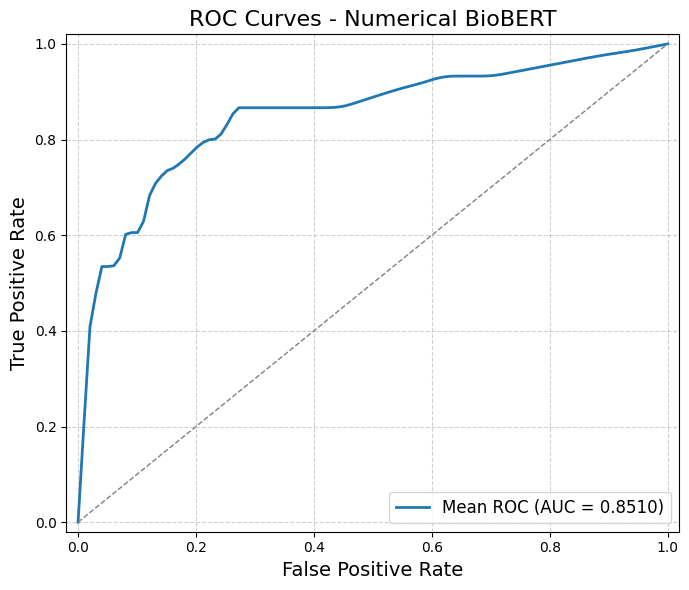

In [20]:
numerical_biobert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_biobert_train,
    test_df=df_numerical_biobert_test,
    embedding_cols=[col for col in df_numerical_biobert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=significant_categories,
    model_name="Numerical BioBERT",
    n_bootstrap=1000
)

## Logistic Regression on BioBert embeddings


Running combined logistic regression for BioBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.14

=== Results for BioBERT ===

----- Odds Ratios (one-time fit) -----
                                Odds Ratio  95% CI Lower  95% CI Upper  \
const                         1.782928e+00           0.0           inf   
Orientation_Time_Embedding_0  8.793990e-01           0.0           inf   
Orientation_Time_Embedding_1  1.147077e+00           0.0           inf   
Orientation_Time_Embedding_2  2.577225e+00           NaN           NaN   
Orientation_Time_Embedding_3  1.022934e+00           NaN           NaN   
...                                    ...           ...           ...   
Language_Embedding_763        3.917473e-02           0.0           inf   
Language_Embedding_764        9.338597e+02           0.0           inf   
Language_Embedding_765        6.513501e-04           0.0           inf   
Language_Embedding_766        1.751743e-13           0.0           inf   
Language_Embedding_767        4.226853e+02           0.0           inf   

 

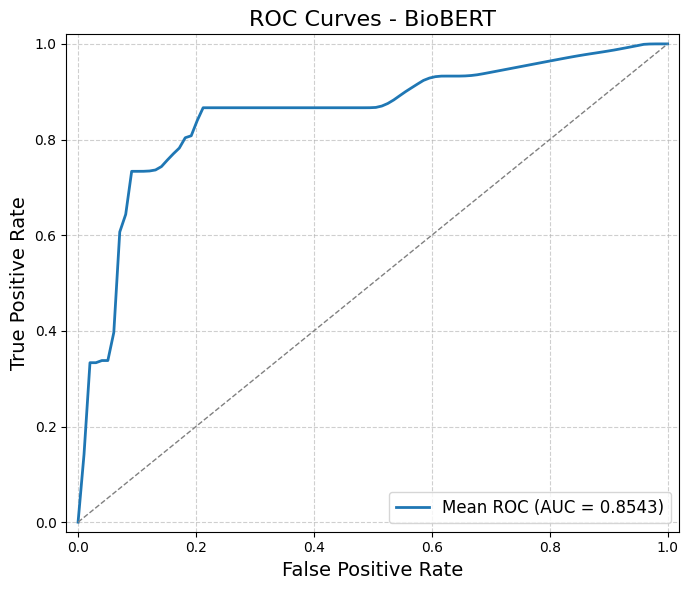

In [21]:
biobert_combined_result = run_logistic_regression_pipeline(
    train_df=df_biobert_train,
    test_df=df_biobert_test,
    embedding_cols=[col for col in df_biobert_train.columns if col.startswith('Embedding_')],
    categories=significant_categories,
    model_name="BioBERT"
)

## Logistic Regression on Contextual BioBert embeddings


Running combined logistic regression for Contextual BioBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Pytho


=== Results for Contextual BioBERT ===

----- Odds Ratios (one-time fit) -----
                                        Odds Ratio  95% CI Lower  \
const                                          inf           0.0   
Orientation_Time_Context_Embedding_0  6.320909e-27           0.0   
Orientation_Time_Context_Embedding_1           inf           0.0   
Orientation_Time_Context_Embedding_2  0.000000e+00           0.0   
Orientation_Time_Context_Embedding_3           inf           NaN   
...                                            ...           ...   
Language_Context_Embedding_763                 inf           0.0   
Language_Context_Embedding_764        0.000000e+00           NaN   
Language_Context_Embedding_765        0.000000e+00           NaN   
Language_Context_Embedding_766        0.000000e+00           0.0   
Language_Context_Embedding_767                 inf           0.0   

                                      95% CI Upper   p-value  
const                                   

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


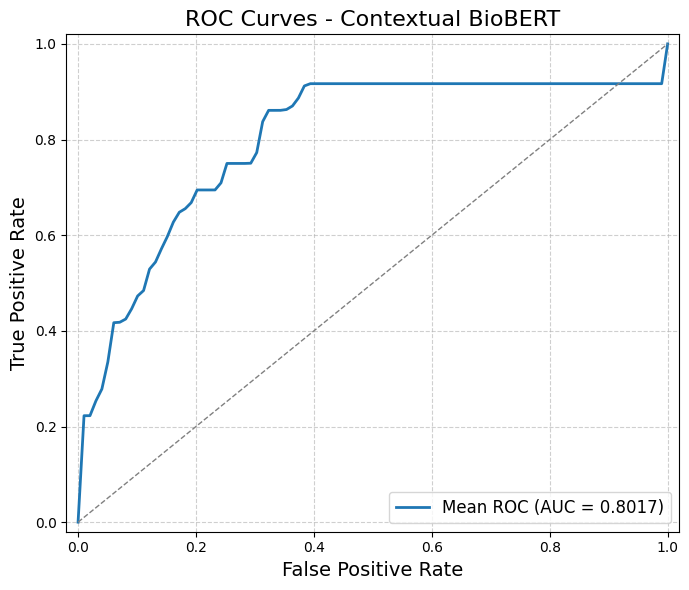

In [22]:
context_biobert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_biobert_train,
    test_df=df_context_biobert_test,
    embedding_cols=[col for col in df_context_biobert_train.columns if col.startswith('Context_Embedding_')],
    categories=significant_categories,
    model_name="Contextual BioBERT"
)

## Logisitic Regression on Numerical MedBERT Embeddings


Running combined logistic regression for Numerical MedBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.21

=== Results for Numerical MedBERT ===

----- Odds Ratios (one-time fit) -----
                                        Odds Ratio  95% CI Lower  \
const                                     1.002573           NaN   
Orientation_Time_Numerical_Embedding_0    0.981101           NaN   
Orientation_Time_Numerical_Embedding_1    0.991788           0.0   
Orientation_Time_Numerical_Embedding_2    1.018963           NaN   
Orientation_Time_Numerical_Embedding_3    0.989548           NaN   
...                                            ...           ...   
Language_Numerical_Embedding_763          1.003785           0.0   
Language_Numerical_Embedding_764          1.011292           NaN   
Language_Numerical_Embedding_765          1.005675           0.0   
Language_Numerical_Embedding_766          1.002077           NaN   
Language_Numerical_Embedding_767          0.991697           NaN   

                                        95% CI Upper  p-value  

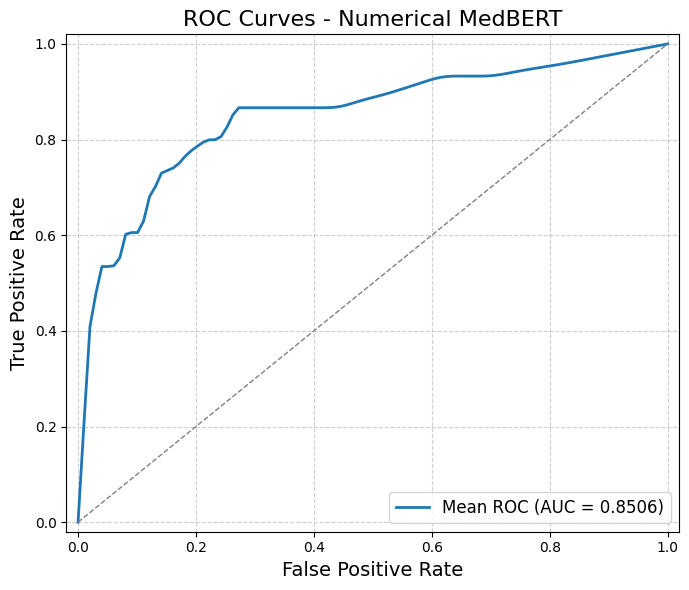

In [23]:
numerical_medbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_medbert_train,
    test_df=df_numerical_medbert_test,
    embedding_cols=[col for col in df_numerical_medbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=significant_categories,
    model_name="Numerical MedBERT",
    n_bootstrap=1000
)

## Logistic Regression on MedBERT embeddings


Running combined logistic regression for MedBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.14

=== Results for MedBERT ===

----- Odds Ratios (one-time fit) -----
                              Odds Ratio  95% CI Lower  95% CI Upper   p-value
const                           1.625721           0.0           inf  0.999999
Orientation_Time_Embedding_0    1.281003           NaN           NaN       NaN
Orientation_Time_Embedding_1    0.862500           0.0           inf  1.000000
Orientation_Time_Embedding_2    0.709981           0.0           inf  0.999997
Orientation_Time_Embedding_3    1.034460           NaN           NaN       NaN
...                                  ...           ...           ...       ...
Language_Embedding_763         13.488646           NaN           NaN       NaN
Language_Embedding_764          1.276551           0.0           inf  1.000000
Language_Embedding_765          0.255028           NaN           NaN       NaN
Language_Embedding_766          0.499079           0.0           inf  0.999999
Language_Embedding_76

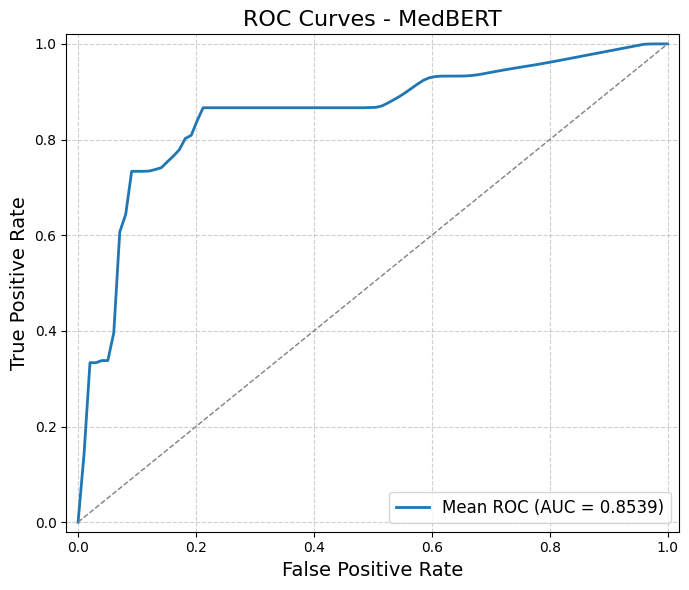

In [24]:
medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_medbert_train,
    test_df=df_medbert_test,
    embedding_cols=[col for col in df_medbert_train.columns if col.startswith('Embedding_')],
    categories=significant_categories,
    model_name="MedBERT"
)

## Logisitc Regression on Contextual MedBERT embeddings


Running combined logistic regression for Contextual MedBERT (mean embeddings per category per visit)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.34

=== Results for Contextual MedBERT ===

----- Odds Ratios (one-time fit) -----
                                      Odds Ratio  95% CI Lower  95% CI Upper  \
const                                   1.049552           NaN           NaN   
Orientation_Time_Context_Embedding_0    3.033040           0.0           inf   
Orientation_Time_Context_Embedding_1    0.642944           NaN           NaN   
Orientation_Time_Context_Embedding_2    2.103048           NaN           NaN   
Orientation_Time_Context_Embedding_3    1.846192           0.0           inf   
...                                          ...           ...           ...   
Language_Context_Embedding_763          0.101150           0.0           inf   
Language_Context_Embedding_764        225.905587           0.0           inf   
Language_Context_Embedding_765          4.495677           NaN           NaN   
Language_Context_Embedding_766          0.005608           0.0           inf   

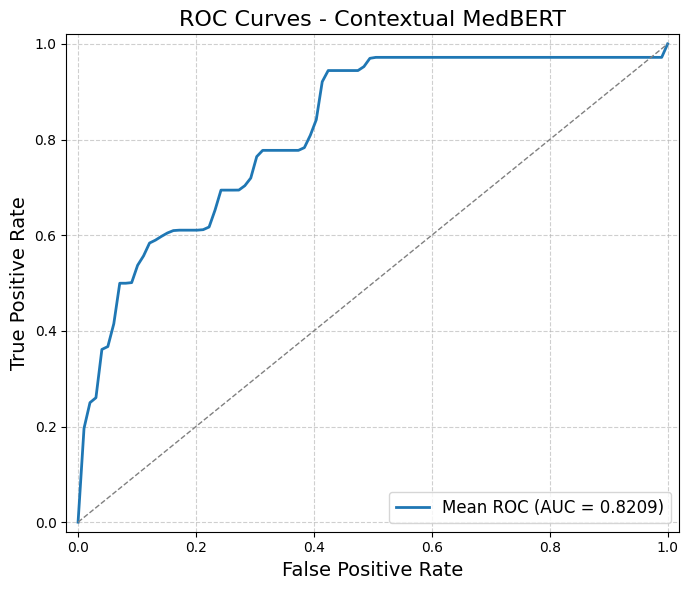

In [25]:
context_medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_medbert_train,
    test_df=df_context_medbert_test,
    embedding_cols=[col for col in df_context_medbert_train.columns if col.startswith('Context_Embedding_')],
    categories=significant_categories,
    model_name="Contextual MedBERT"
)

## Display the results from each model

In [26]:
import pandas as pd

# Collect results from each combined model
combined_model_results = [
                        mmsescore_results,
                        combined_category_results,
                        # significant_combined_results,
                        numerical_clinicalbert_combined_results,
                        clinicalbert_combined_result,
                        context_clinicalbert_combined_result,
                        numerical_biobert_combined_results,
                        biobert_combined_result,
                        context_biobert_combined_result,
                        numerical_medbert_combined_results,
                        medbert_combined_result,
                        context_medbert_combined_result
                        ]
# Define model names
combined_model_names = [
                    'MMSE Score',
                    'MMSE Categories',
                    # 'Significant MMSE Categories',
                    'Numerical ClinicalBERT',
                    'ClinicalBERT',
                    'Contextual ClinicalBERT',
                    'Numerical BioBERT',
                    'BioBERT',
                    'Contextual BioBERT',
                    'Numerical MedBERT',
                    'MedBERT',
                    'Contextual MedBERT'
                    ]

# Initialize list to store summary rows
summary_rows = []

for result, name in zip(combined_model_results, combined_model_names):
    row = {'Model': name}

    # Extract best threshold
    # row['Best Threshold'] = result.get('Best Threshold', None)

    # Extract bootstrapped metrics
    for metric_name, (mean, ci) in result['Bootstrapped Metrics'].items():
        row[f'{metric_name}'] = round(mean, 4)
        # row[f'{metric_name} 95% CI Lower'] = round(ci[0], 4)
        # row[f'{metric_name} 95% CI Upper'] = round(ci[1], 4)

    summary_rows.append(row)

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Display the summary DataFrame
from IPython.display import display
print("=== Summary of Combined Model Results ===")
display(summary_df)

# Save the summary DataFrame to a CSV file
summary_df.to_csv("data/Combined_Model_Metrics_Summary.csv", index=False)


=== Summary of Combined Model Results ===


,Model,AUC,Balanced Accuracy,Sensitivity,Specificity,Precision,F1-score
0,MMSE Score,0.8639,0.8087,0.6671,0.9503,0.7097,0.6873
1,MMSE Categories,0.8549,0.7927,0.7336,0.8518,0.4739,0.5756
2,Numerical ClinicalBERT,0.8507,0.7989,0.7336,0.8642,0.4957,0.5914
3,ClinicalBERT,0.7913,0.7951,0.8001,0.7900,0.4095,0.5416
4,Contextual ClinicalBERT,0.8207,0.7329,0.5827,0.8830,0.4865,0.5302
5,Numerical BioBERT,0.8510,0.7989,0.7336,0.8642,0.4957,0.5914
6,BioBERT,0.8543,0.8282,0.8665,0.7900,0.4289,0.5737
7,Contextual BioBERT,0.8017,0.7527,0.7501,0.7554,0.3684,0.4941
8,Numerical MedBERT,0.8506,0.7989,0.7336,0.8642,0.4957,0.5914
9,MedBERT,0.8539,0.8282,0.8665,0.7900,0.4289,0.5737


In [27]:
# Extract and display Odds Ratios for combined_category_results
import pandas as pd

# Assuming combined_category_results is already computed
odds_ratios = significant_combined_results["Odds Ratios (one-time fit)"]

# Convert to DataFrame if not already
if isinstance(odds_ratios, dict):
    odds_ratios_df = pd.DataFrame.from_dict(odds_ratios, orient='index', columns=['Odds Ratio'])
else:
    odds_ratios_df = odds_ratios

# Display the table
print("=== Odds Ratios for Statistically Significant MMSE Categories ===")
print(odds_ratios_df)

# Save to CSV (optional)
# odds_ratios_df.to_csv("data/Odds_Ratios_Combined_Category_Results.csv", index=True)

=== Odds Ratios for Statistically Significant MMSE Categories ===
                          Odds Ratio  95% CI Lower  95% CI Upper       p-value
const                  404239.467499   5707.062523  2.863286e+07  2.864661e-09
Orientation_Time            0.366535      0.274015  4.902938e-01  1.360848e-11
Orientation_Place           0.466215      0.299230  7.263862e-01  7.437902e-04
Attention_Calculation       0.627587      0.471508  8.353302e-01  1.406803e-03
Recall                      0.521653      0.428073  6.356919e-01  1.110436e-10
Language                    0.675502      0.442353  1.031534e+00  6.933577e-02


## ROC Curves for the different models

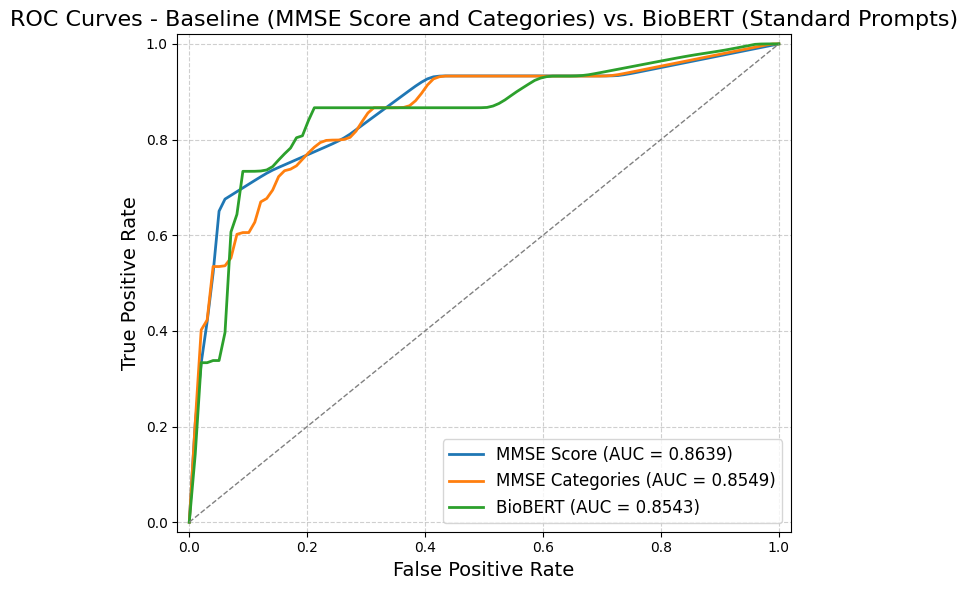

In [30]:
# Function to plot ROC Curves for specified models (Styled)
def plot_multiple_bootstrapped_roc_curves(roc_dict, title="Bootstrapped ROC Curves"):
    """
    roc_dict: dict of {label: bootstrapped_roc_curve_dict}
    """
    plt.figure(figsize=(7, 6))
    for label, roc_data in roc_dict.items():
        mean_fpr = roc_data["Mean FPR"]
        mean_tpr = roc_data["Mean TPR"]
        mean_auc = roc_data["Mean AUC"]
        plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{label} (AUC = {mean_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_multiple_bootstrapped_roc_curves(
    {
        "MMSE Score": mmsescore_results["Bootstrapped ROC Curve"],
        "MMSE Categories": combined_category_results["Bootstrapped ROC Curve"],
        "BioBERT": biobert_combined_result["Bootstrapped ROC Curve"],
    },
    title="ROC Curves - Baseline (MMSE Score and Categories) vs. BioBERT (Standard Prompts)"
)


## Confusion Matrix

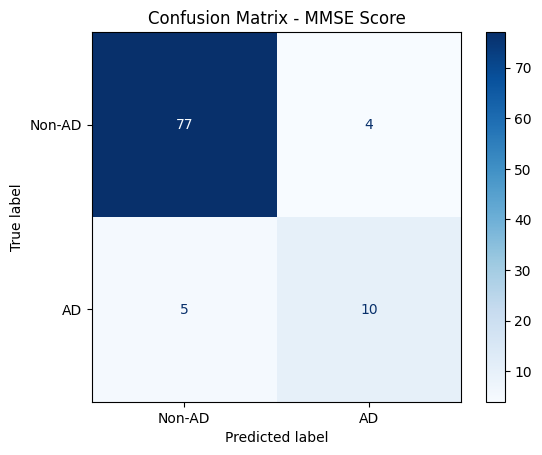

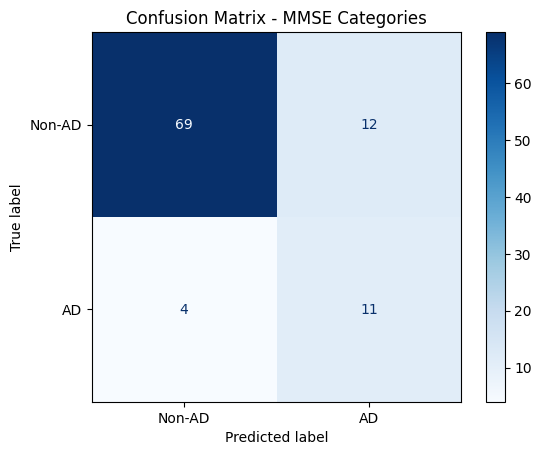

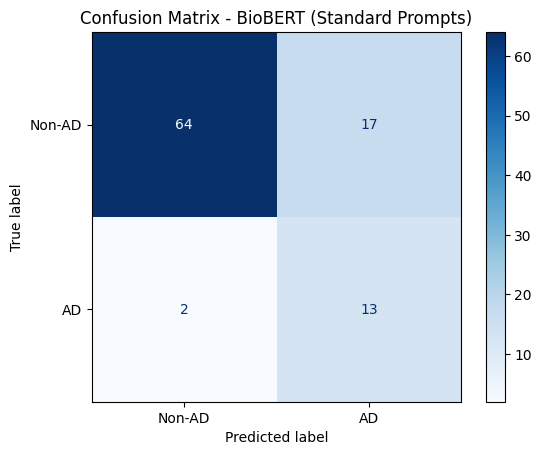

In [29]:
def generate_and_plot_confusion_matrix(y_true, y_pred_probs, threshold, title='Confusion Matrix'):
    """
    Generate and plot a confusion matrix using scikit-learn metrics.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred_probs: Predicted probabilities.
    - threshold: Threshold for converting probabilities to binary predictions.
    - title: Title for the confusion matrix plot.

    Returns:
    - Confusion matrix as a numpy array.
    - Classification report as a string.
    """
    # Convert probabilities to binary predictions using the threshold
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Generate a classification report
    report = classification_report(y_true, y_pred, target_names=['Non-AD', 'AD'])
    
    # Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AD', 'AD'])
    cm_display.plot(cmap='Blues')
    plt.title(title)
    plt.show()
    
    # return cm, report

# Confuse matrix for MMSE Score
score_y_true = mmsescore_results["True Labels"]
score_y_pred_probs = mmsescore_results["Predicted Probabilities"]
score_threshold = mmsescore_results['Best Threshold']
generate_and_plot_confusion_matrix(score_y_true, score_y_pred_probs, score_threshold, title="Confusion Matrix - MMSE Score")

# Confuse matrix for MMSE Categories
categories_y_true = combined_category_results["True Labels"]
categories_y_pred_probs = combined_category_results["Predicted Probabilities"]
categories_threshold = combined_category_results['Best Threshold']
generate_and_plot_confusion_matrix(categories_y_true, categories_y_pred_probs, categories_threshold, title="Confusion Matrix - MMSE Categories")

# Confuse matrix for BioBERT (Standard Prompts)
biobert_y_true = biobert_combined_result["True Labels"]
biobert_y_pred_probs = biobert_combined_result["Predicted Probabilities"]
biobert_threshold = biobert_combined_result['Best Threshold']
generate_and_plot_confusion_matrix(biobert_y_true, biobert_y_pred_probs, biobert_threshold, title="Confusion Matrix - BioBERT (Standard Prompts)")